In [1]:
import torch
from torch import nn
from torch.nn.parameter import Parameter
from torch import distributions
import sys
sys.path.append('/home/anjali/learn_from_sparse/flowgmm')
import numpy as np
torch.manual_seed(0)
np.random.seed(0)

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
from pylab import rcParams
rcParams['figure.figsize'] = 10, 8
rcParams['figure.dpi'] = 300

# from flow_ssl.realnvp.realnvp_toy import ToyRealNVP
from flow_ssl.realnvp.realnvp import RealNVPTabular
from flow_ssl.data import make_dataset_from_pkl
from flow_ssl.distributions import SSLGaussMixture
from flow_ssl import FlowLoss

from itertools import chain

%load_ext autoreload
%autoreload 2

In [2]:
def grid_image(mapping, xx, yy, extradim=False):
    lines = np.hstack([xx.reshape([-1, 1]), yy.reshape([-1, 1])])
    if extradim:
        lines = lines[:, None, :]
    lines = torch.from_numpy(lines).float()
    img_lines = mapping(lines).detach().numpy()
    
    if extradim:
        img_xx, img_yy = img_lines[:, 0, 0], img_lines[:, 0, 1]
    else:
        img_xx, img_yy = img_lines[:, 0], img_lines[:, 1]
    img_xx = img_xx.reshape(xx.shape)
    img_yy = img_yy.reshape(yy.shape)
    return img_xx, img_yy

In [3]:
from scipy.spatial.distance import cdist

def get_decision_boundary(f_xx, f_yy, prior):
    f_points = np.hstack([f_xx.reshape([-1, 1]), f_yy.reshape([-1, 1])])
    classes = prior.classify(torch.from_numpy(f_points).float()).detach().numpy()
    return classes

In [4]:
def get_means(n_classes, r):
    phis = np.linspace(0, 2 * np.pi, n_classes+1)[:-1]
    mean_x = np.cos(phis) * r
    mean_y = np.sin(phis) * r
    means = np.hstack([mean_x[:, None], mean_y[:, None]])
    means = torch.from_numpy(means).float()
    return means

## Failure Distribution

In [5]:
r = 5
n_classes = 2
means = get_means(n_classes,r)
prior = SSLGaussMixture(means=means)

data, labels = make_dataset_from_pkl("/home/anjali/learn_from_sparse/f1tenth/data/gpr/sim/f1tenth_cluster_train.pkl") #("/home/anjali/learn_from_sparse/pusht/verify_manipulation/data/pusht_fail_dist_2d_extra.pkl")
print(data.shape, labels.shape)
flow = RealNVPTabular(num_coupling_layers=20, in_dim=2, num_layers=1, hidden_dim=32)
loss_fn = FlowLoss(prior)

(900, 2) (900,)


/home/anjali/anaconda3/envs/flowgmm/lib/python3.12/site-packages/torch/nn/utils/weight_norm.py:28: UserWarning: torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.
  warnings.warn("torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.")


In [8]:
lr_init = 1e-4
epochs = 3000

n_ul = np.sum(labels == -1)
n_l = np.shape(labels)[0] - n_ul
batch_size = n_l
print_freq = 500

labeled_data = data[labels != -1]
labeled_labels = labels[labels != -1]
unlabeled_data = data[labels == -1]
unlabeled_labels = labels[labels == -1]

optimizer = torch.optim.Adam([p for p in flow.parameters() if p.requires_grad==True], lr=lr_init, 
                             weight_decay=1e-2)
for t in range(epochs):    
    
    #batch_idx = np.random.choice(n_ul, size=batch_size)
    #batch_x, batch_y = unlabeled_data[batch_idx].reshape((-1,1)), unlabeled_labels[batch_idx]
    batch_x = labeled_data
    batch_y = labeled_labels
    batch_x, batch_y = torch.from_numpy(batch_x), torch.from_numpy(batch_y)
    z = flow(batch_x.float())
    sldj = flow.logdet().reshape(-1,1)

    loss = loss_fn(z, sldj, batch_y)
    
    optimizer.zero_grad()
    loss.backward()#retain_graph=True)
    optimizer.step()
    
    if t % print_freq == 0:
        print('iter %s:' % t, 'loss = %.3f' % loss)
        
    if t == int(epochs * 0.5) or t == int(epochs * 0.8):
        for p in optimizer.param_groups:
            p["lr"] /= 10

/home/anjali/learn_from_sparse/flowgmm/flow_ssl/distributions.py:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  mixture_log_probs = torch.logsumexp(all_log_probs + torch.log(F.softmax(self.weights)), dim=1)


iter 0: loss = 15.434
iter 500: loss = 15.216
iter 1000: loss = 15.000
iter 1500: loss = 14.794
iter 2000: loss = 14.776
iter 2500: loss = 14.765


In [9]:
z = flow(torch.from_numpy(data).float())
print(min(z[:,1]),max(z[:,1]))

tensor(-3.3976, grad_fn=<UnbindBackward0>) tensor(3.9541, grad_fn=<UnbindBackward0>)


/tmp/ipykernel_3627012/3450694005.py:33: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(z[:, 0], z[:, 1], cmap=plt.cm.rainbow)
/tmp/ipykernel_3627012/3450694005.py:62: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(x[:, 0], x[:, 1], cmap=plt.cm.rainbow)


(0.0, 5.0)

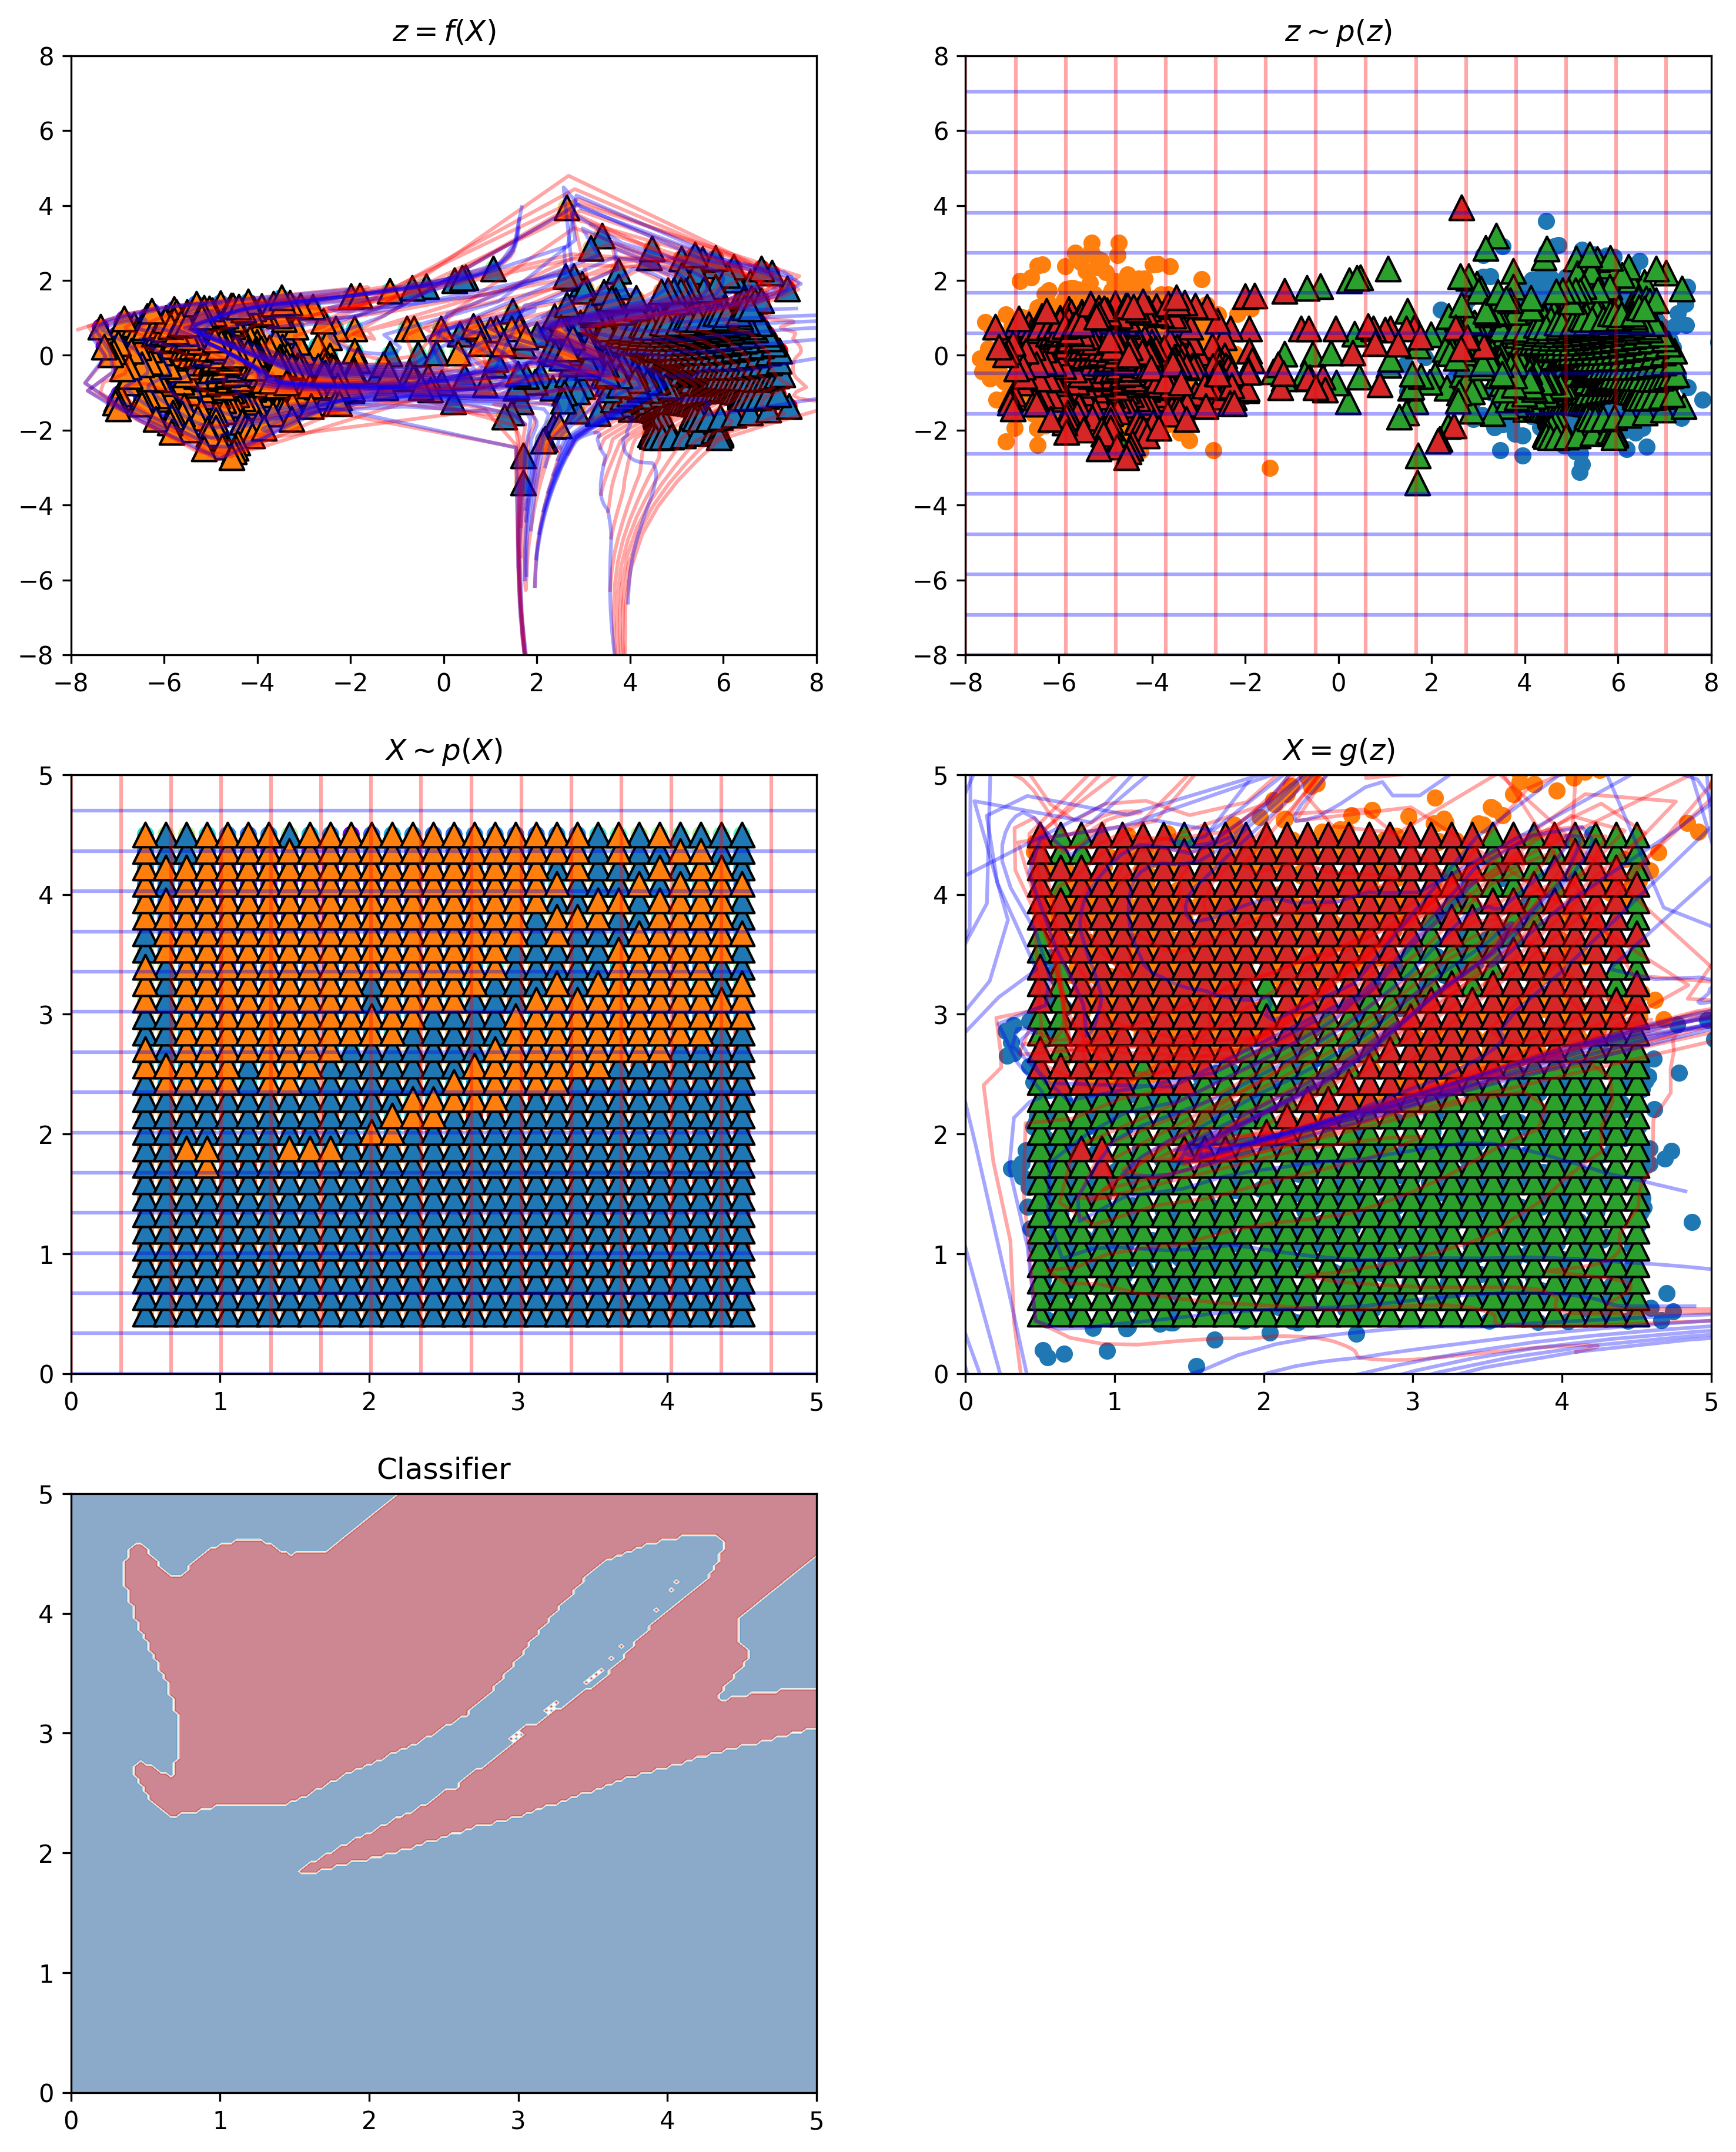

In [13]:
plt.figure(figsize=(12, 15))


grid_points = 150
grid_freq = 10
z_lims = np.array([-8, 8])
x_lims = np.array([0, 5])
line_z = np.linspace(*z_lims, grid_points)
line_x = np.linspace(*x_lims, grid_points)
xx_z, yy_z = np.meshgrid(line_z, line_z)
xx_x, yy_x = np.meshgrid(line_x, line_x)


inv = flow(torch.from_numpy(data).float()).detach().numpy()

plt.subplot(321)
plt.scatter(inv[:, 0], inv[:, 1], c=inv[:, 0], cmap=plt.cm.rainbow)
for i in range(int(np.max(labels) + 1)):
    plt.scatter(inv[labels==i][:, 0], inv[labels==i][:, 1], marker="^", s=100, edgecolor="k")
f_xx, f_yy = grid_image(flow, xx_x, yy_x)
plt.plot(f_xx[:, ::grid_freq], f_yy[:, ::grid_freq], '-r', alpha=0.35)
f_xx_, f_yy_ = grid_image(flow, yy_x, xx_x)
plt.plot(f_xx_[:, ::grid_freq], f_yy_[:, ::grid_freq], '-b', alpha=0.35)
plt.title(r'$z = f(X)$')
plt.xlim(z_lims)
plt.ylim(z_lims)

plt.subplot(322)
zs = []
for i in range(len(means)):
    z = loss_fn.prior.sample((1000,), gaussian_id=i).numpy()
    zs.append(z)
    plt.scatter(z[:, 0], z[:, 1], cmap=plt.cm.rainbow)
plt.plot(xx_z[:, ::grid_freq], yy_z[:, ::grid_freq], '-r', alpha=0.35)
plt.plot(yy_z[:, ::grid_freq], xx_z[:, ::grid_freq], '-b', alpha=0.35)
for i in range(int(np.max(labels) + 1)):
    plt.scatter(inv[labels==i][:, 0], inv[labels==i][:, 1], marker="^", s=100, edgecolor="k")
plt.title(r'$z \sim p(z)$')
plt.xlim(z_lims)
plt.ylim(z_lims)

plt.subplot(323)
plt.scatter(data[:, 0], data[:, 1], c=inv[:, 0], cmap=plt.cm.rainbow)
for i in range(int(np.max(labels) + 1)):
    plt.scatter(data[labels==i][:, 0], data[labels==i][:, 1], marker="^", s=100, edgecolor="k")
plt.plot(xx_x[:, ::grid_freq], yy_x[:, ::grid_freq], '-r', alpha=0.35)
plt.plot(yy_x[:, ::grid_freq], xx_x[:, ::grid_freq], '-b', alpha=0.35)
plt.title(r'$X \sim p(X)$')
plt.xlim(x_lims)
plt.ylim(x_lims)


plt.subplot(324)
g_xx, g_yy = grid_image(flow.inverse, xx_z, yy_z)
plt.plot(g_xx[:, ::grid_freq], g_yy[:, ::grid_freq], '-r', alpha=0.35)
g_xx_, g_yy_ = grid_image(flow.inverse, yy_z, xx_z)
plt.plot(g_xx_[:, ::grid_freq], g_yy_[:, ::grid_freq], '-b', alpha=0.35)
xs = []

for z in zs:
    x = flow.inverse(torch.from_numpy(z).float()).detach().numpy()
    plt.scatter(x[:, 0], x[:, 1], cmap=plt.cm.rainbow)
    xs.append(x)
    
for i in range(int(np.max(labels) + 1)):
    plt.scatter(data[labels==i][:, 0], data[labels==i][:, 1], marker="^", s=100, edgecolor="k")
    
plt.title(r'$X = g(z)$')
plt.xlim(x_lims)
plt.ylim(x_lims)

plt.subplot(325)
classes = get_decision_boundary(f_xx, f_yy, prior)
plt.contourf(xx_x, yy_x, classes.reshape(xx_x.shape), cmap="RdBu_r", alpha=0.5)
#plt.scatter(data[:, 0], data[:, 1], c=inv[:, 0], cmap=plt.cm.rainbow, alpha=0.5)
#for i in range(int(np.max(labels) + 1)):
#    plt.scatter(data[labels==i][:, 0], data[labels==i][:, 1], marker="^", s=100, edgecolor="k")
plt.title(r'Classifier')
plt.xlim(x_lims)
plt.ylim(x_lims)

<>:30: SyntaxWarning: invalid escape sequence '\s'
<>:30: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipykernel_3627012/1752707260.py:30: SyntaxWarning: invalid escape sequence '\s'
  """
/tmp/ipykernel_3627012/1752707260.py:22: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(z[:, 0], z[:, 1], cmap=plt.cm.rainbow)
/tmp/ipykernel_3627012/1752707260.py:27: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(x[:, 0], x[:, 1], cmap=plt.cm.rainbow)


'\nplt.plot(xx_z[:, ::grid_freq], yy_z[:, ::grid_freq], \'-r\', alpha=0.35)\nplt.plot(yy_z[:, ::grid_freq], xx_z[:, ::grid_freq], \'-b\', alpha=0.35)\nfor i in range(int(np.max(labels) + 1)):\n    plt.scatter(inv[labels==i][:, 0], inv[labels==i][:, 1], marker="^", s=100, edgecolor="k")\nplt.title(r\'$z \\sim p(z)$\')\nplt.xlim(z_lims)\nplt.ylim(z_lims)\n'

<Figure size 3600x4500 with 0 Axes>

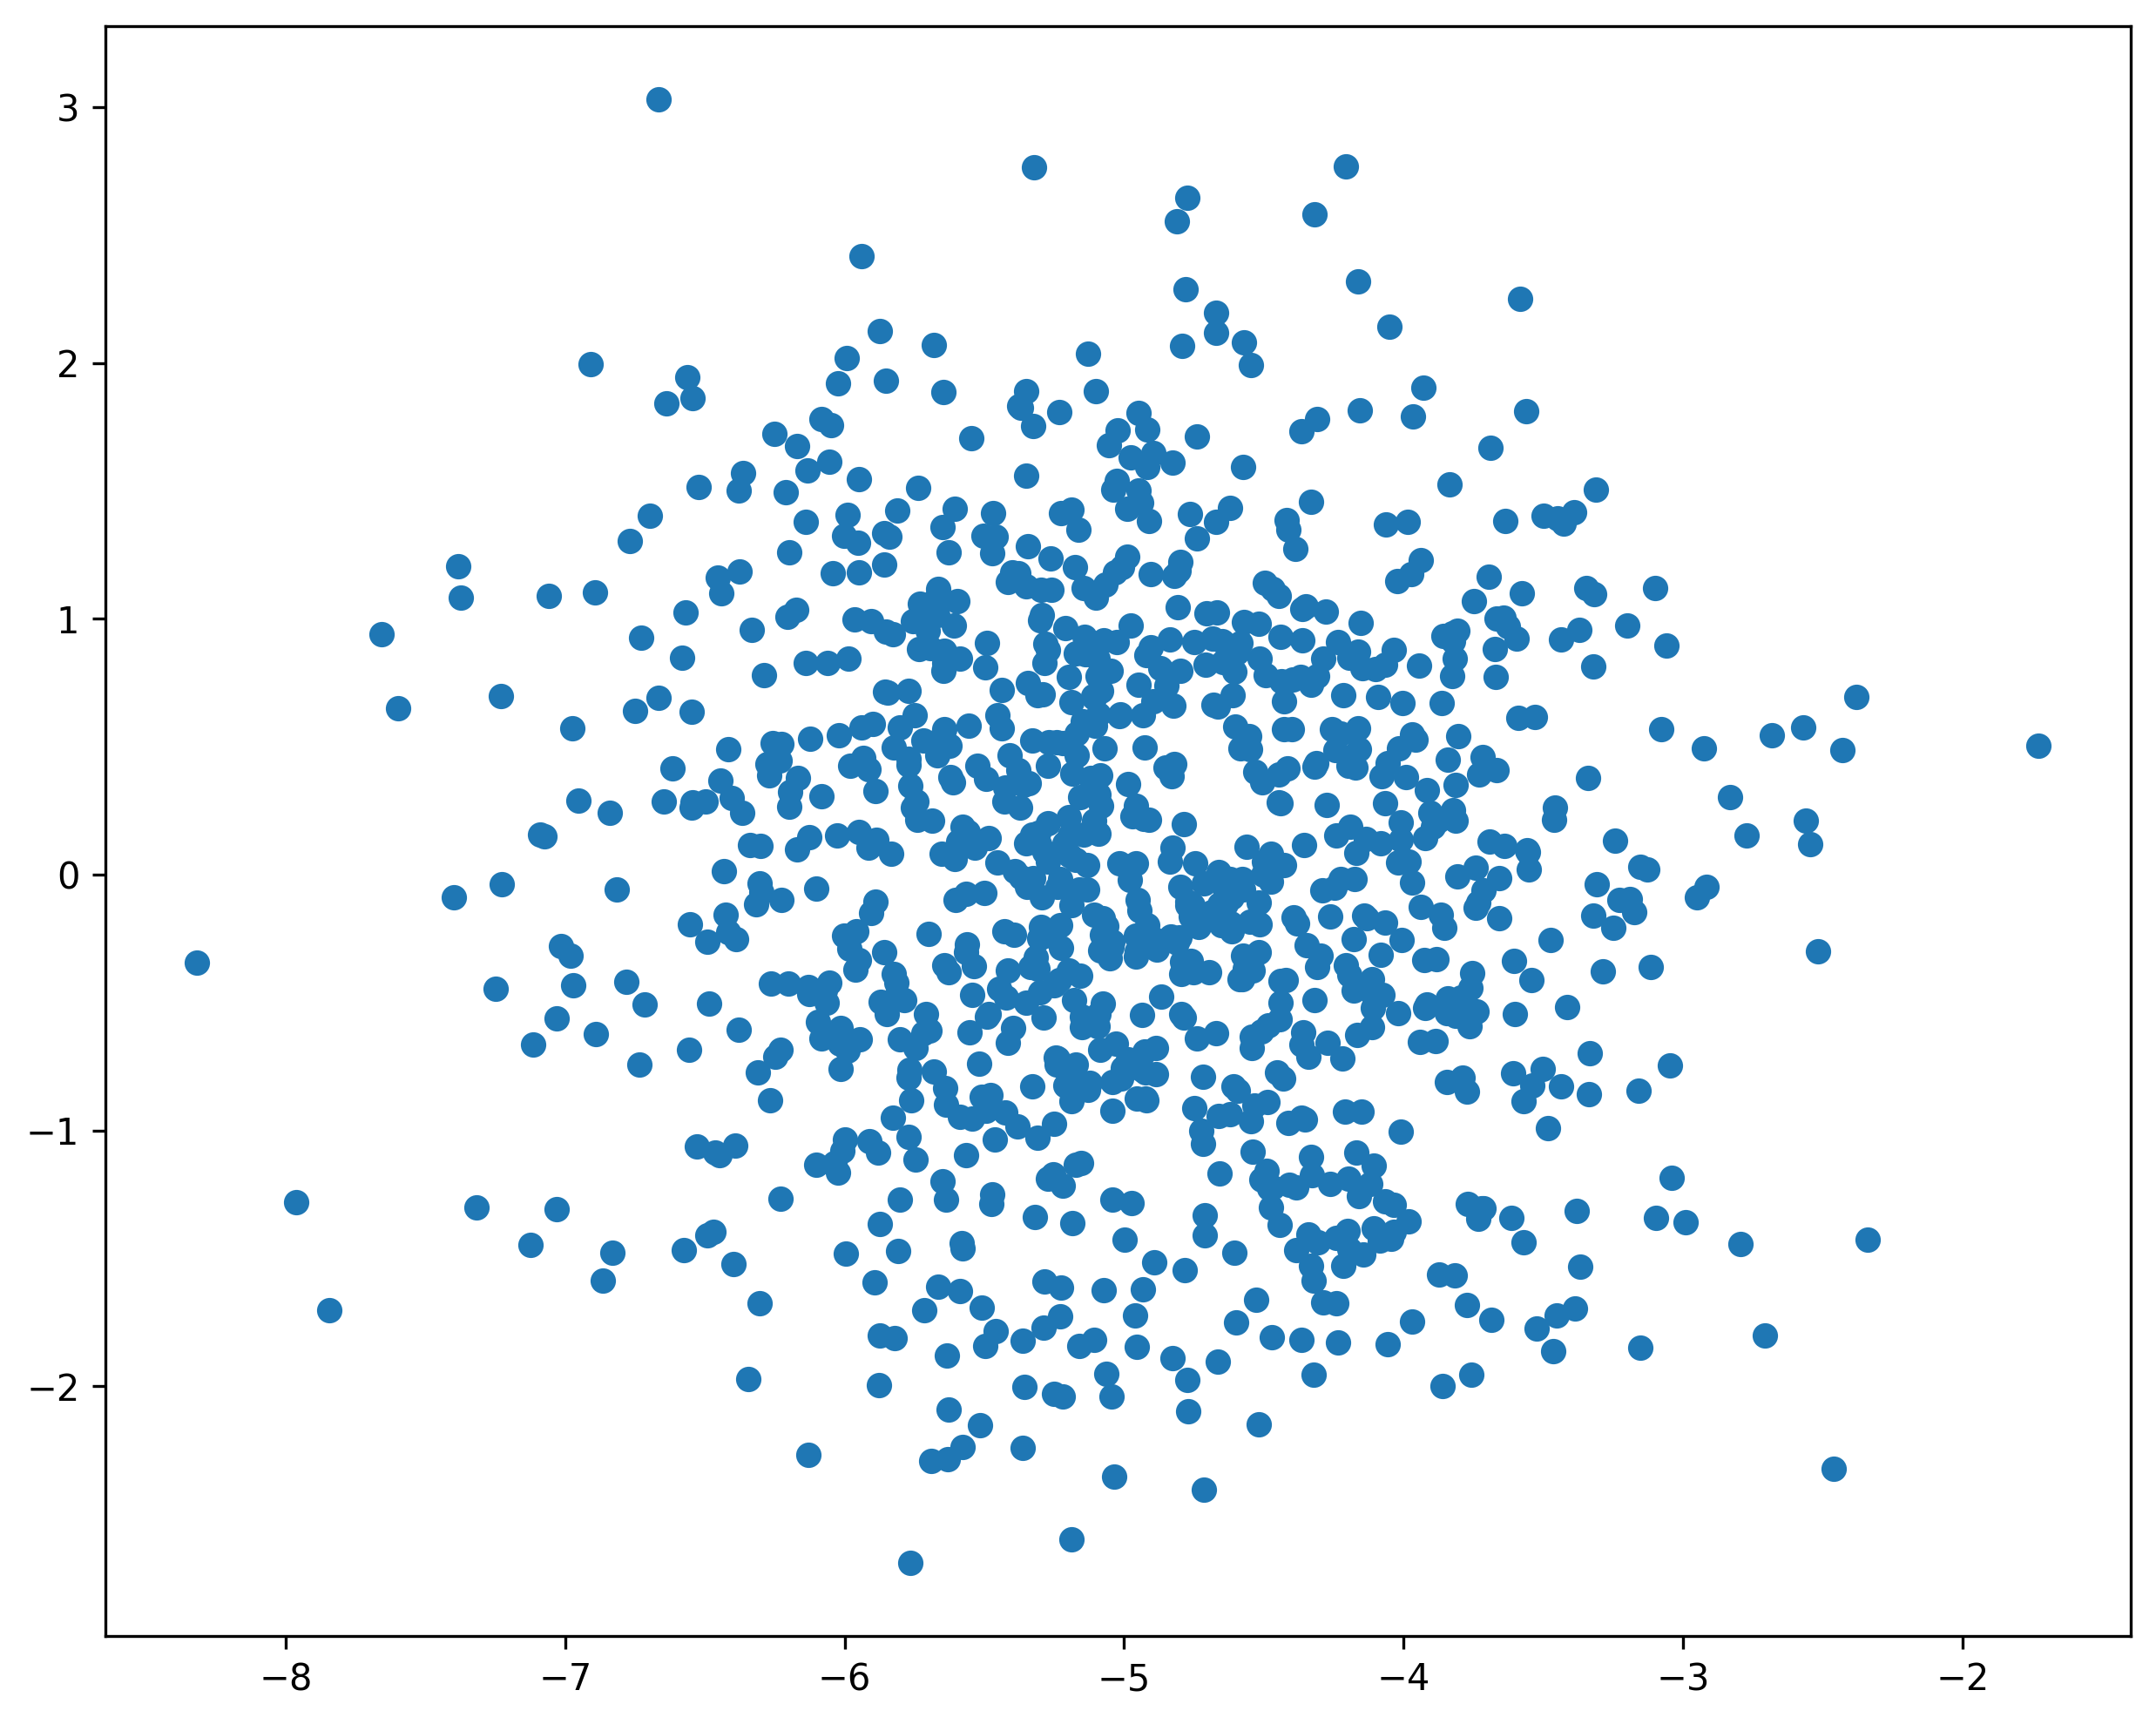

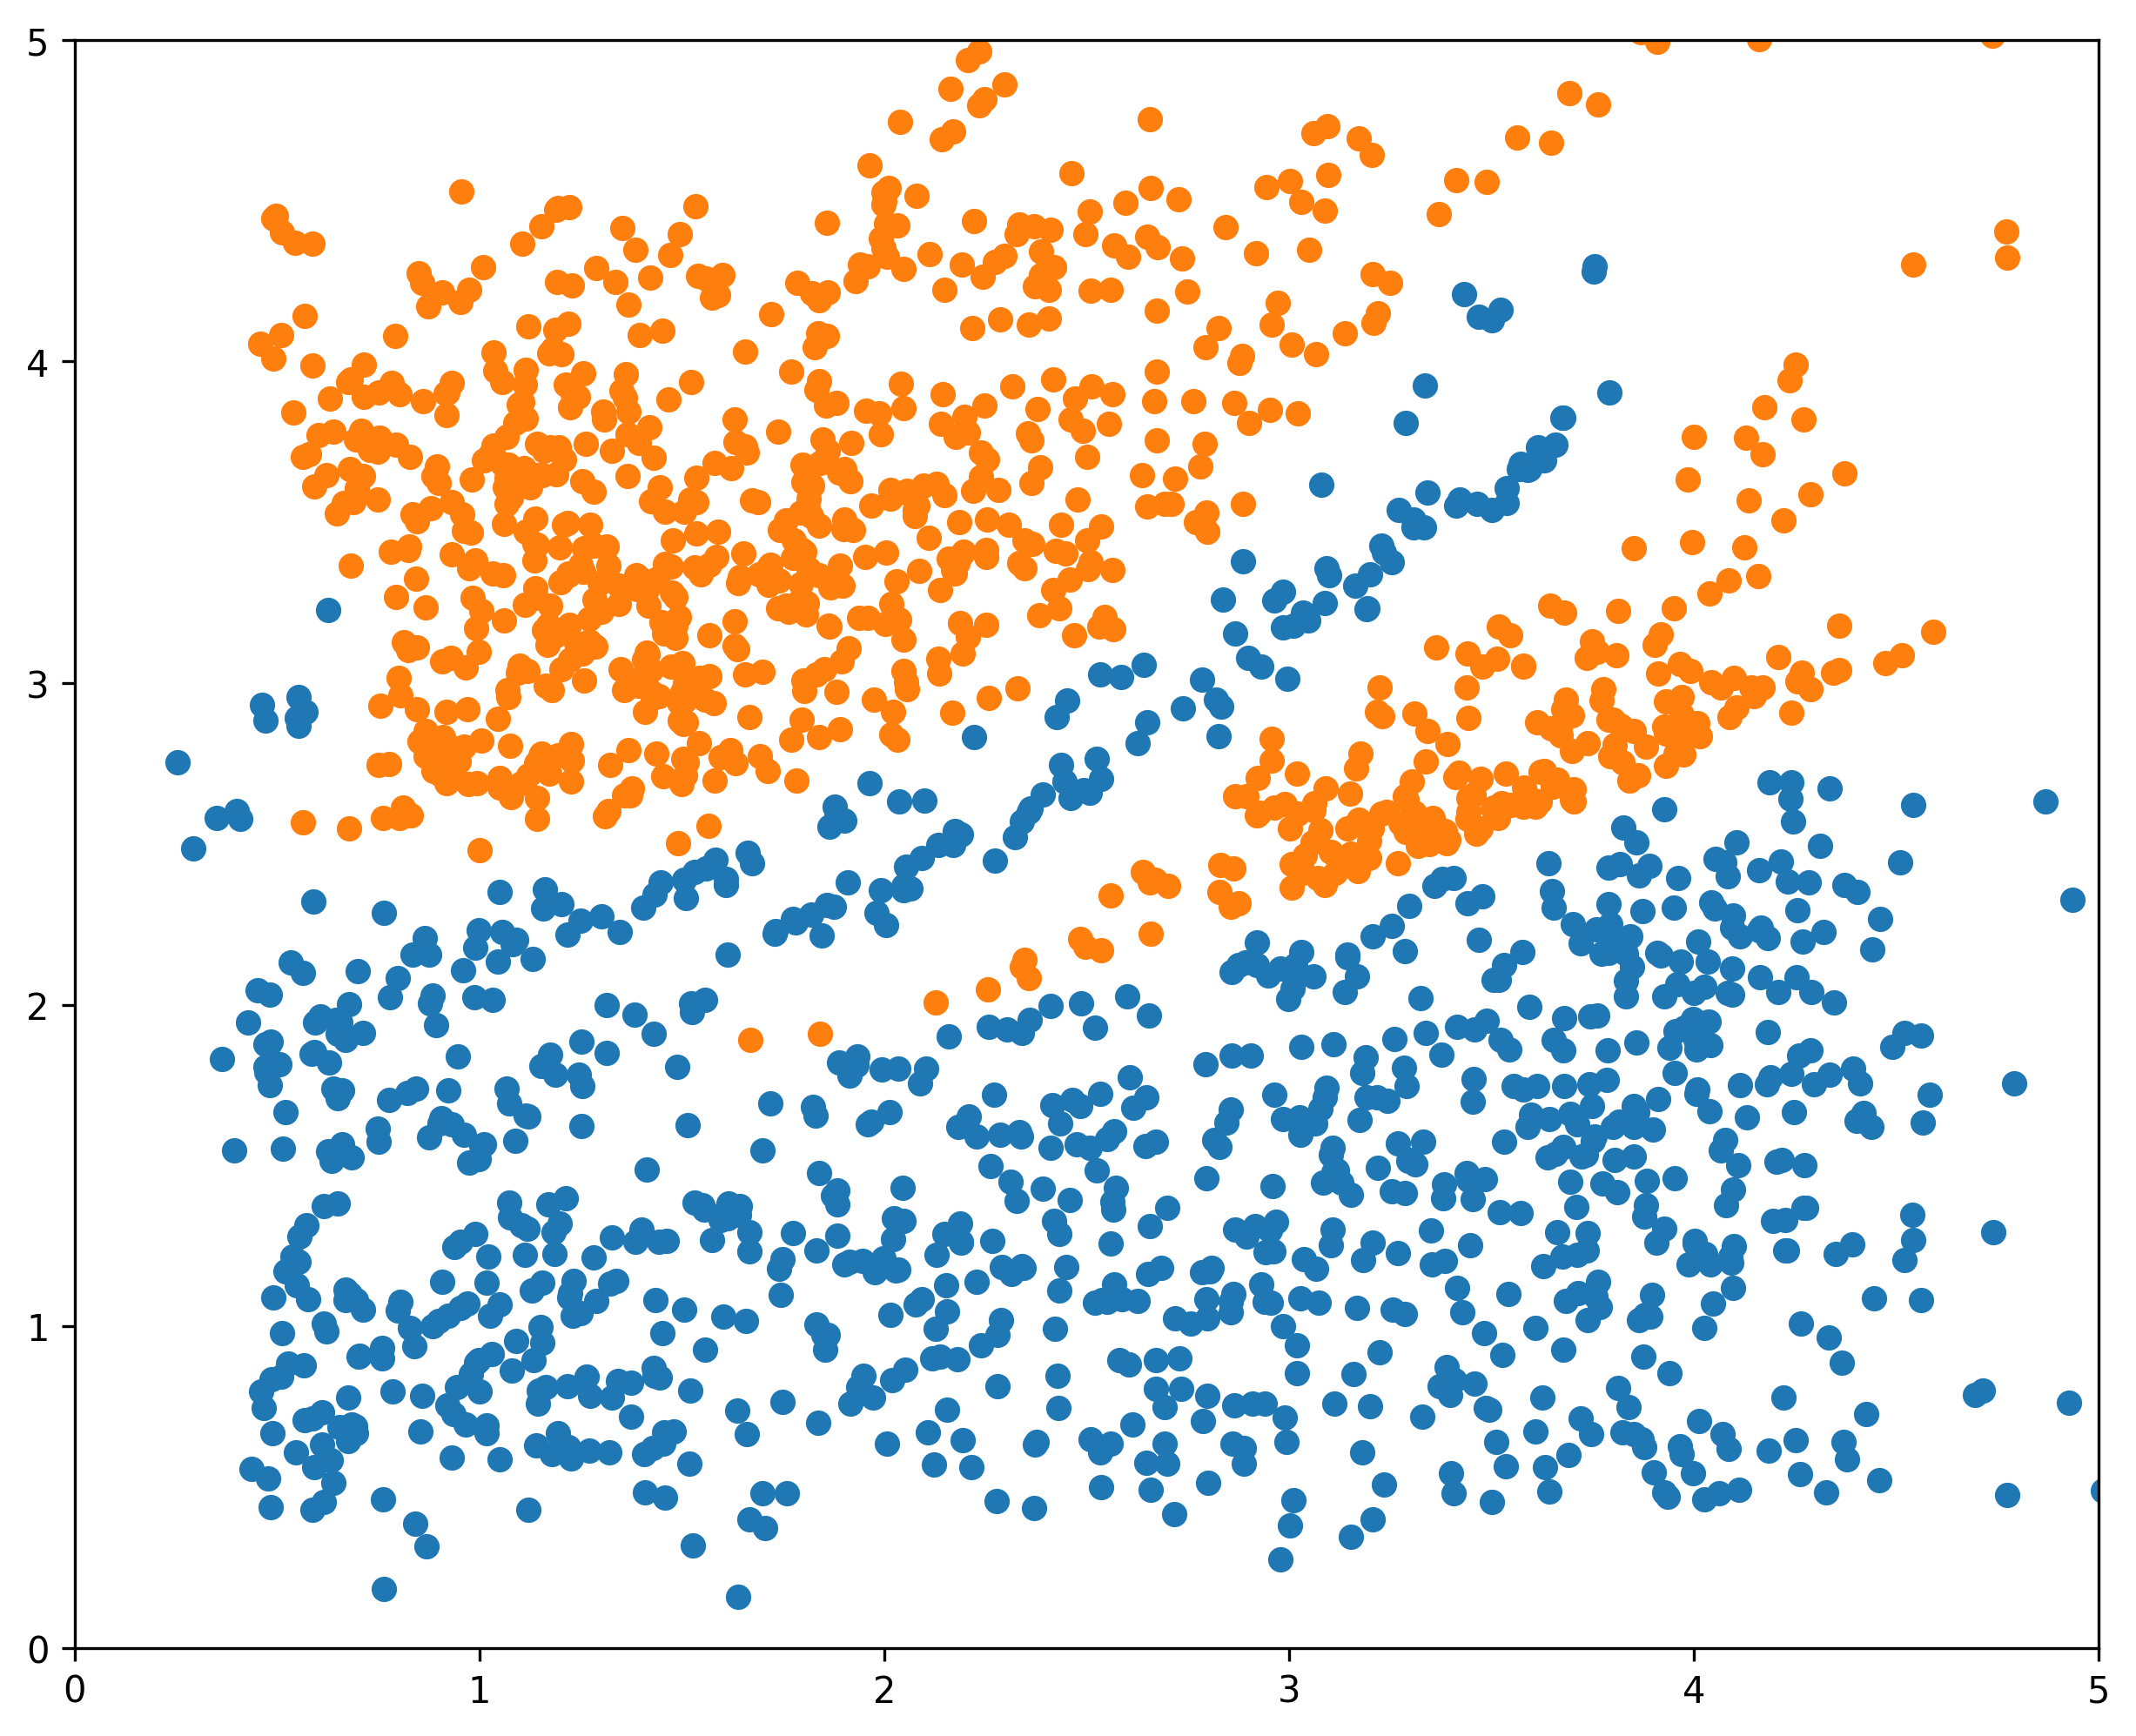

In [15]:
plt.figure(figsize=(12, 15))


grid_points = 150
grid_freq = 10
z_lims = np.array([-8, 8])
x_lims = np.array([0, 5])
line_z = np.linspace(*z_lims, grid_points)
line_x = np.linspace(*x_lims, grid_points)
xx_z, yy_z = np.meshgrid(line_z, line_z)
xx_x, yy_x = np.meshgrid(line_x, line_x)


inv = flow(torch.from_numpy(data).float()).detach().numpy()


plt.figure()
zs = []
for i in range(len(means)):
    z = loss_fn.prior.sample((1000,), gaussian_id=i).numpy()
    zs.append(z)
plt.scatter(z[:, 0], z[:, 1], cmap=plt.cm.rainbow)

plt.figure()
for z in zs:
    x = flow.inverse(torch.from_numpy(z).float()).detach().numpy()
    plt.scatter(x[:, 0], x[:, 1], cmap=plt.cm.rainbow)
    plt.xlim([0,5])
    plt.ylim([0,5])
"""
plt.plot(xx_z[:, ::grid_freq], yy_z[:, ::grid_freq], '-r', alpha=0.35)
plt.plot(yy_z[:, ::grid_freq], xx_z[:, ::grid_freq], '-b', alpha=0.35)
for i in range(int(np.max(labels) + 1)):
    plt.scatter(inv[labels==i][:, 0], inv[labels==i][:, 1], marker="^", s=100, edgecolor="k")
plt.title(r'$z \sim p(z)$')
plt.xlim(z_lims)
plt.ylim(z_lims)
"""



In [16]:
# Additional information
EPOCH = 10000
PATH = "f1tenth_noise_2.pt"
LOSS = 0.4

torch.save({
            'epoch': EPOCH,
            'model_state_dict': flow.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': LOSS,
            }, PATH)

In [21]:
data.shape

(205, 2)

(0.0, 600.0)

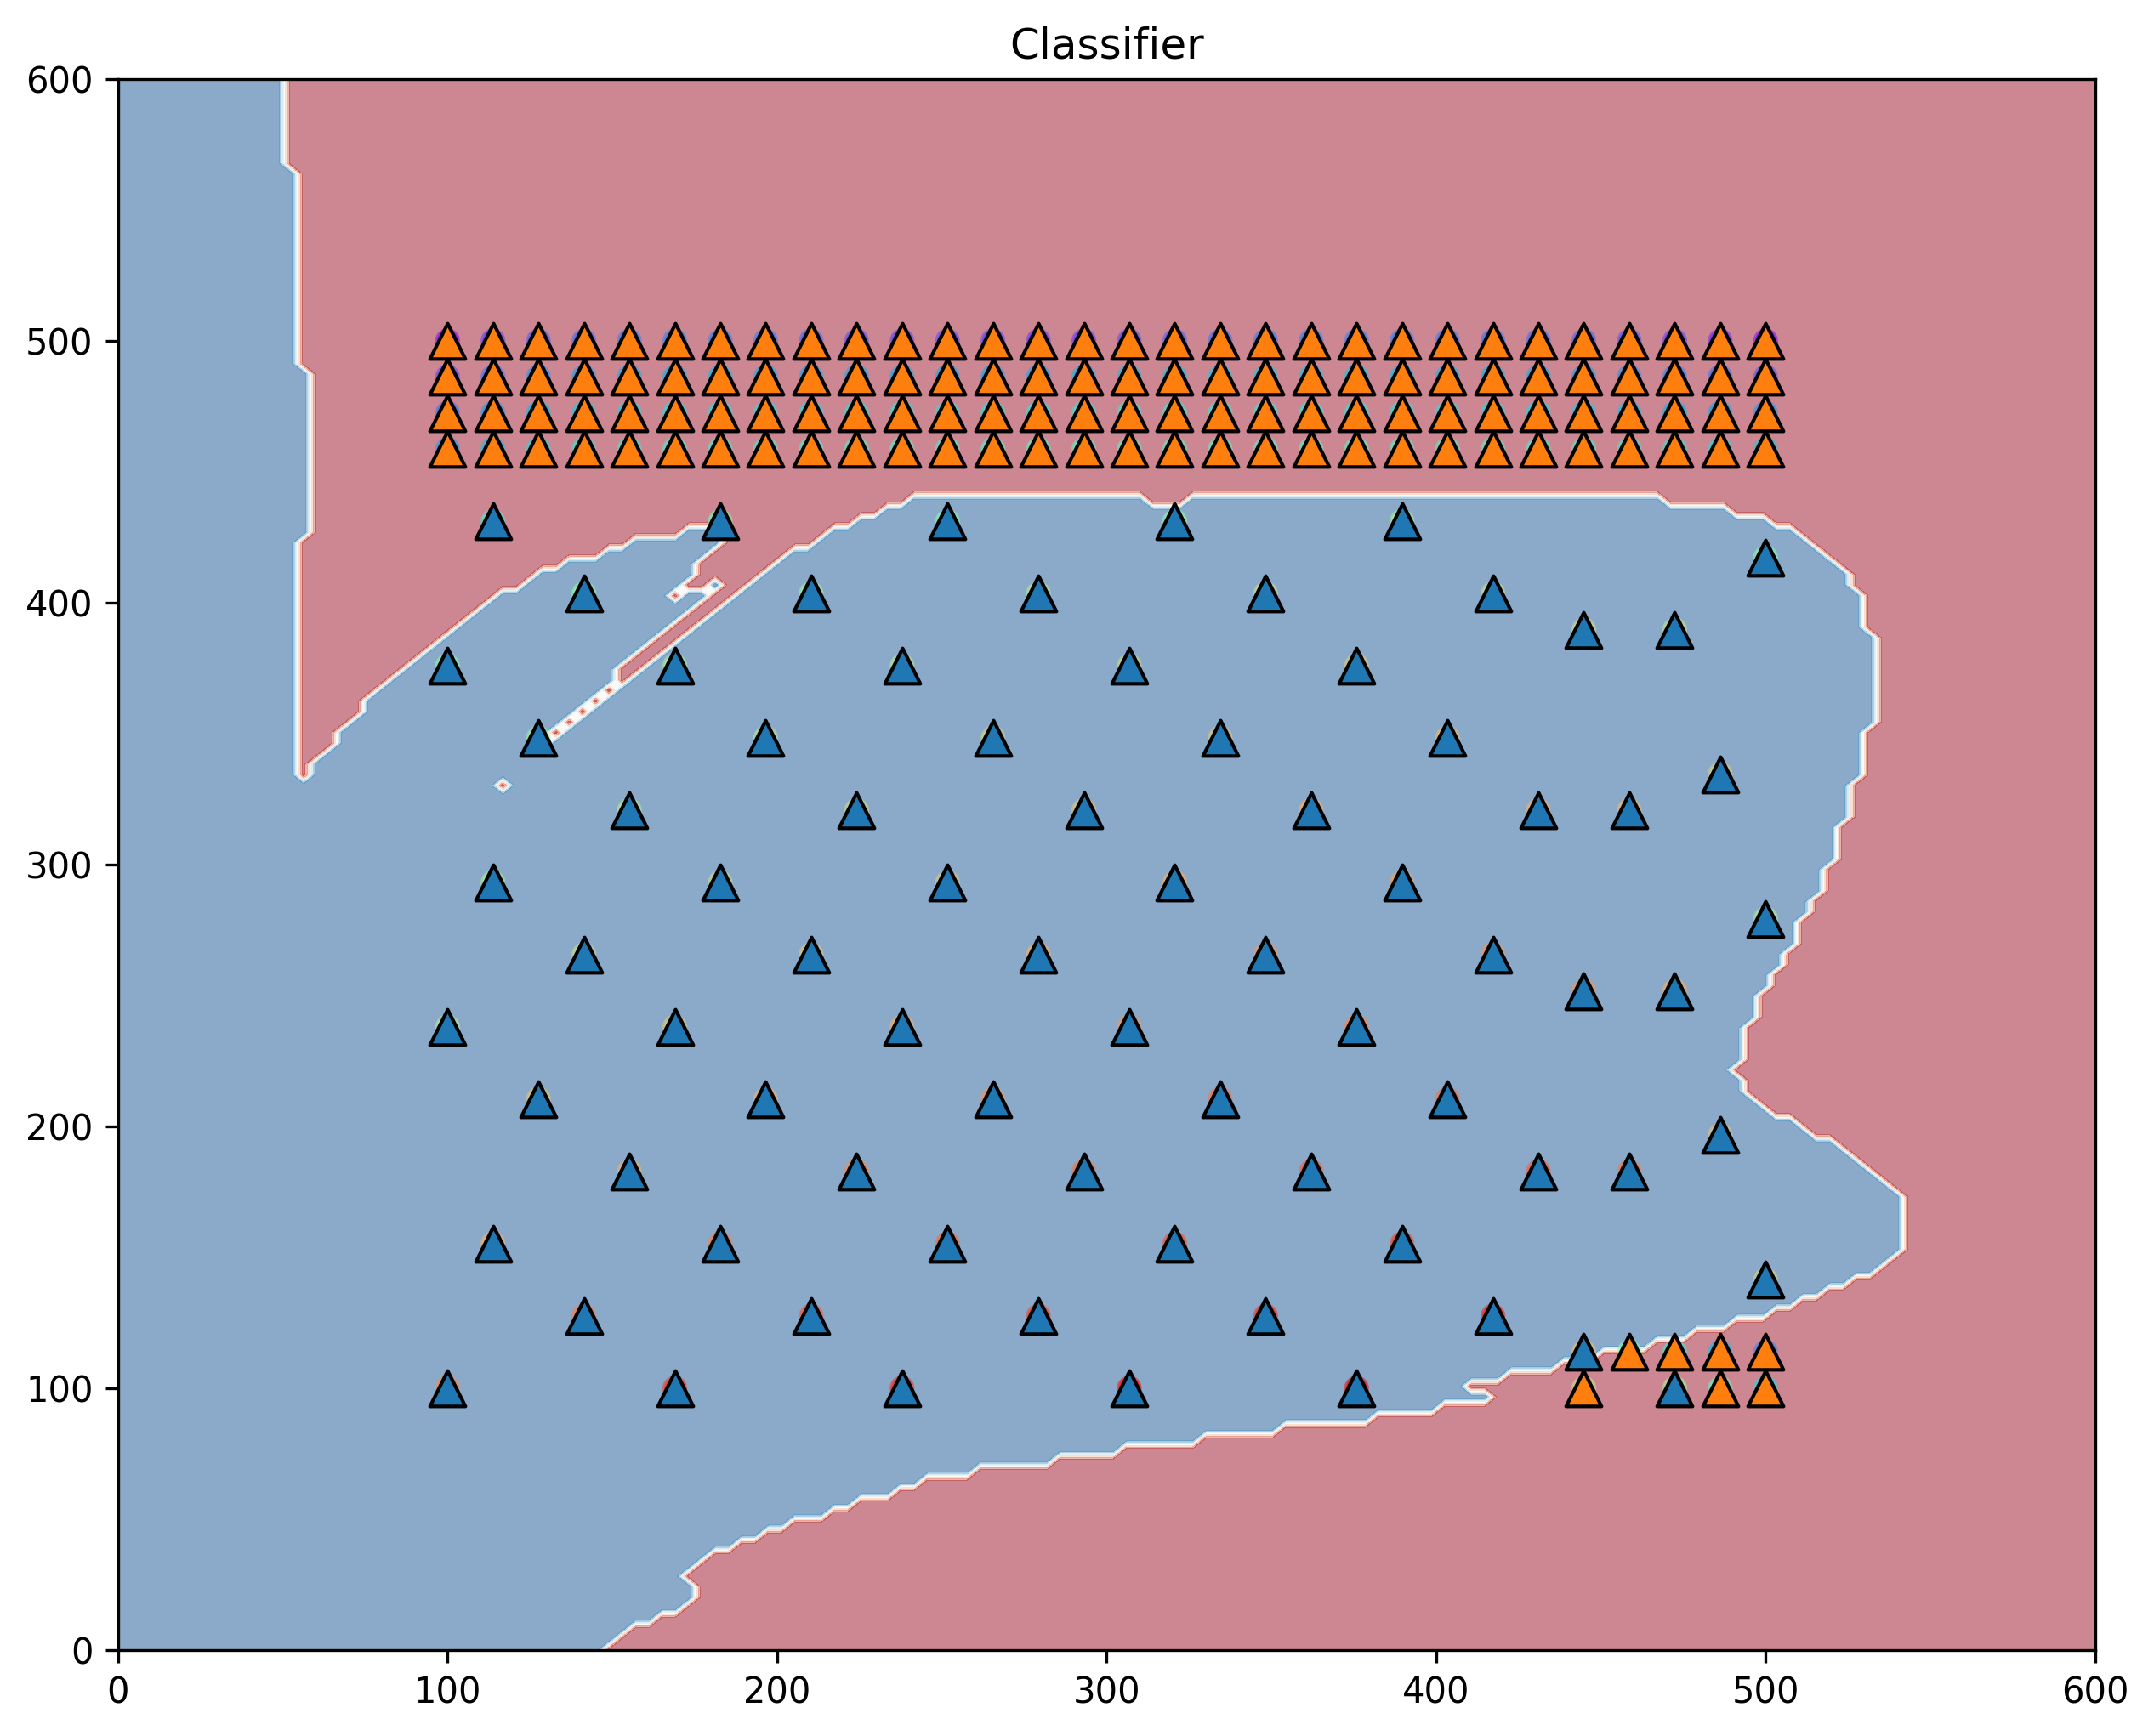

In [20]:
model = RealNVPTabular(num_coupling_layers=20, in_dim=2, num_layers=1, hidden_dim=32)
PATH = "pusht_noise.pt"
checkpoint = torch.load(PATH)
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']
loss = checkpoint['loss']

model.eval()
inv_ = model(torch.from_numpy(data).float()).detach().numpy()
classes = get_decision_boundary(f_xx, f_yy, prior)
plt.contourf(xx_x, yy_x, classes.reshape(xx_x.shape), cmap="RdBu_r", alpha=0.5)
plt.scatter(data[:, 0], data[:, 1], c=inv_[:, 0], cmap=plt.cm.rainbow, alpha=0.5)
for i in range(int(np.max(labels) + 1)):
    plt.scatter(data[labels==i][:, 0], data[labels==i][:, 1], marker="^", s=100, edgecolor="k")
plt.title(r'Classifier')
plt.xlim(x_lims)
plt.ylim(x_lims)

In [13]:
plt.figure(figsize=(12, 15))


grid_points = 150
grid_freq = 10
z_lims = np.array([-5, 5])
x_lims = np.array([75, 500])
line_z = np.linspace(*z_lims, grid_points)
line_x = np.linspace(*x_lims, grid_points)
xx_z, yy_z = np.meshgrid(line_z, line_z)
xx_x, yy_x = np.meshgrid(line_x, line_x)


#inv = flow(torch.from_numpy(data)).detach().numpy()
inv_ = model(torch.from_numpy(data)).detach().numpy()
plt.subplot(321)
plt.scatter(inv[:, 0], inv[:, 1], c=inv[:, 0], cmap=plt.cm.rainbow)
for i in range(int(np.max(labels) + 1)):
    plt.scatter(inv[labels==i][:, 0], inv[labels==i][:, 1], marker="^", s=100, edgecolor="k")
f_xx, f_yy = grid_image(model, xx_x, yy_x)
plt.plot(f_xx[:, ::grid_freq], f_yy[:, ::grid_freq], '-r', alpha=0.35)
f_xx_, f_yy_ = grid_image(model, yy_x, xx_x)
plt.plot(f_xx_[:, ::grid_freq], f_yy_[:, ::grid_freq], '-b', alpha=0.35)
plt.title(r'$u = f(Z)$')
plt.xlim(z_lims)
plt.ylim(z_lims)

plt.subplot(322)
zs = []
for i in range(len(means)):
    z = loss_fn.prior.sample((1000,), gaussian_id=i).numpy()
    zs.append(z)
    plt.scatter(z[:, 0], z[:, 1], cmap=plt.cm.rainbow)
plt.plot(xx_z[:, ::grid_freq], yy_z[:, ::grid_freq], '-r', alpha=0.35)
plt.plot(yy_z[:, ::grid_freq], xx_z[:, ::grid_freq], '-b', alpha=0.35)
for i in range(int(np.max(labels) + 1)):
    plt.scatter(inv[labels==i][:, 0], inv[labels==i][:, 1], marker="^", s=100, edgecolor="k")
plt.title(r'$u \sim p(u)$')
plt.xlim(z_lims)
plt.ylim(z_lims)

plt.subplot(323)
plt.scatter(data[:, 0], data[:, 1], c=inv[:, 0], cmap=plt.cm.rainbow)
for i in range(int(np.max(labels) + 1)):
    plt.scatter(data[labels==i][:, 0], data[labels==i][:, 1], marker="^", s=100, edgecolor="k")
plt.plot(xx_x[:, ::grid_freq], yy_x[:, ::grid_freq], '-r', alpha=0.35)
plt.plot(yy_x[:, ::grid_freq], xx_x[:, ::grid_freq], '-b', alpha=0.35)
plt.title(r'$[X_0,Y_0] \sim p(Z)$')
plt.xlim(x_lims)
plt.ylim(x_lims)


plt.subplot(323)
g_xx, g_yy = grid_image(model.inverse, xx_z, yy_z)
plt.plot(g_xx[:, ::grid_freq], g_yy[:, ::grid_freq], '-r', alpha=0.35)
g_xx_, g_yy_ = grid_image(model.inverse, yy_z, xx_z)
plt.plot(g_xx_[:, ::grid_freq], g_yy_[:, ::grid_freq], '-b', alpha=0.35)
xs = []

for z in zs:
    x = model.inverse(torch.from_numpy(z).float()).detach().numpy()
    plt.scatter(x[:, 0], x[:, 1], cmap=plt.cm.rainbow)
    xs.append(x)
    
for i in range(int(np.max(labels) + 1)):
    plt.scatter(data[labels==i][:, 0], data[labels==i][:, 1], marker="^", s=100, edgecolor="k")
    
plt.title(r'$[X_0,Y_0] = g(u)$')
plt.xlim(x_lims)
plt.ylim(x_lims)

plt.subplot(324)
classes = get_decision_boundary(f_xx, f_yy, prior)
plt.contourf(xx_x, yy_x, classes.reshape(xx_x.shape), cmap="RdBu_r", alpha=0.5)
plt.scatter(data[:, 0], data[:, 1], c=inv[:, 0], cmap=plt.cm.rainbow, alpha=0.5)
for i in range(int(np.max(labels) + 1)):
    plt.scatter(data[labels==i][:, 0], data[labels==i][:, 1], marker="^", s=100, edgecolor="k")
plt.title(r'Classifier')
plt.xlim(x_lims)
plt.ylim(x_lims)

NameError: name 'model' is not defined

<Figure size 3600x4500 with 0 Axes>

(75.0, 500.0)

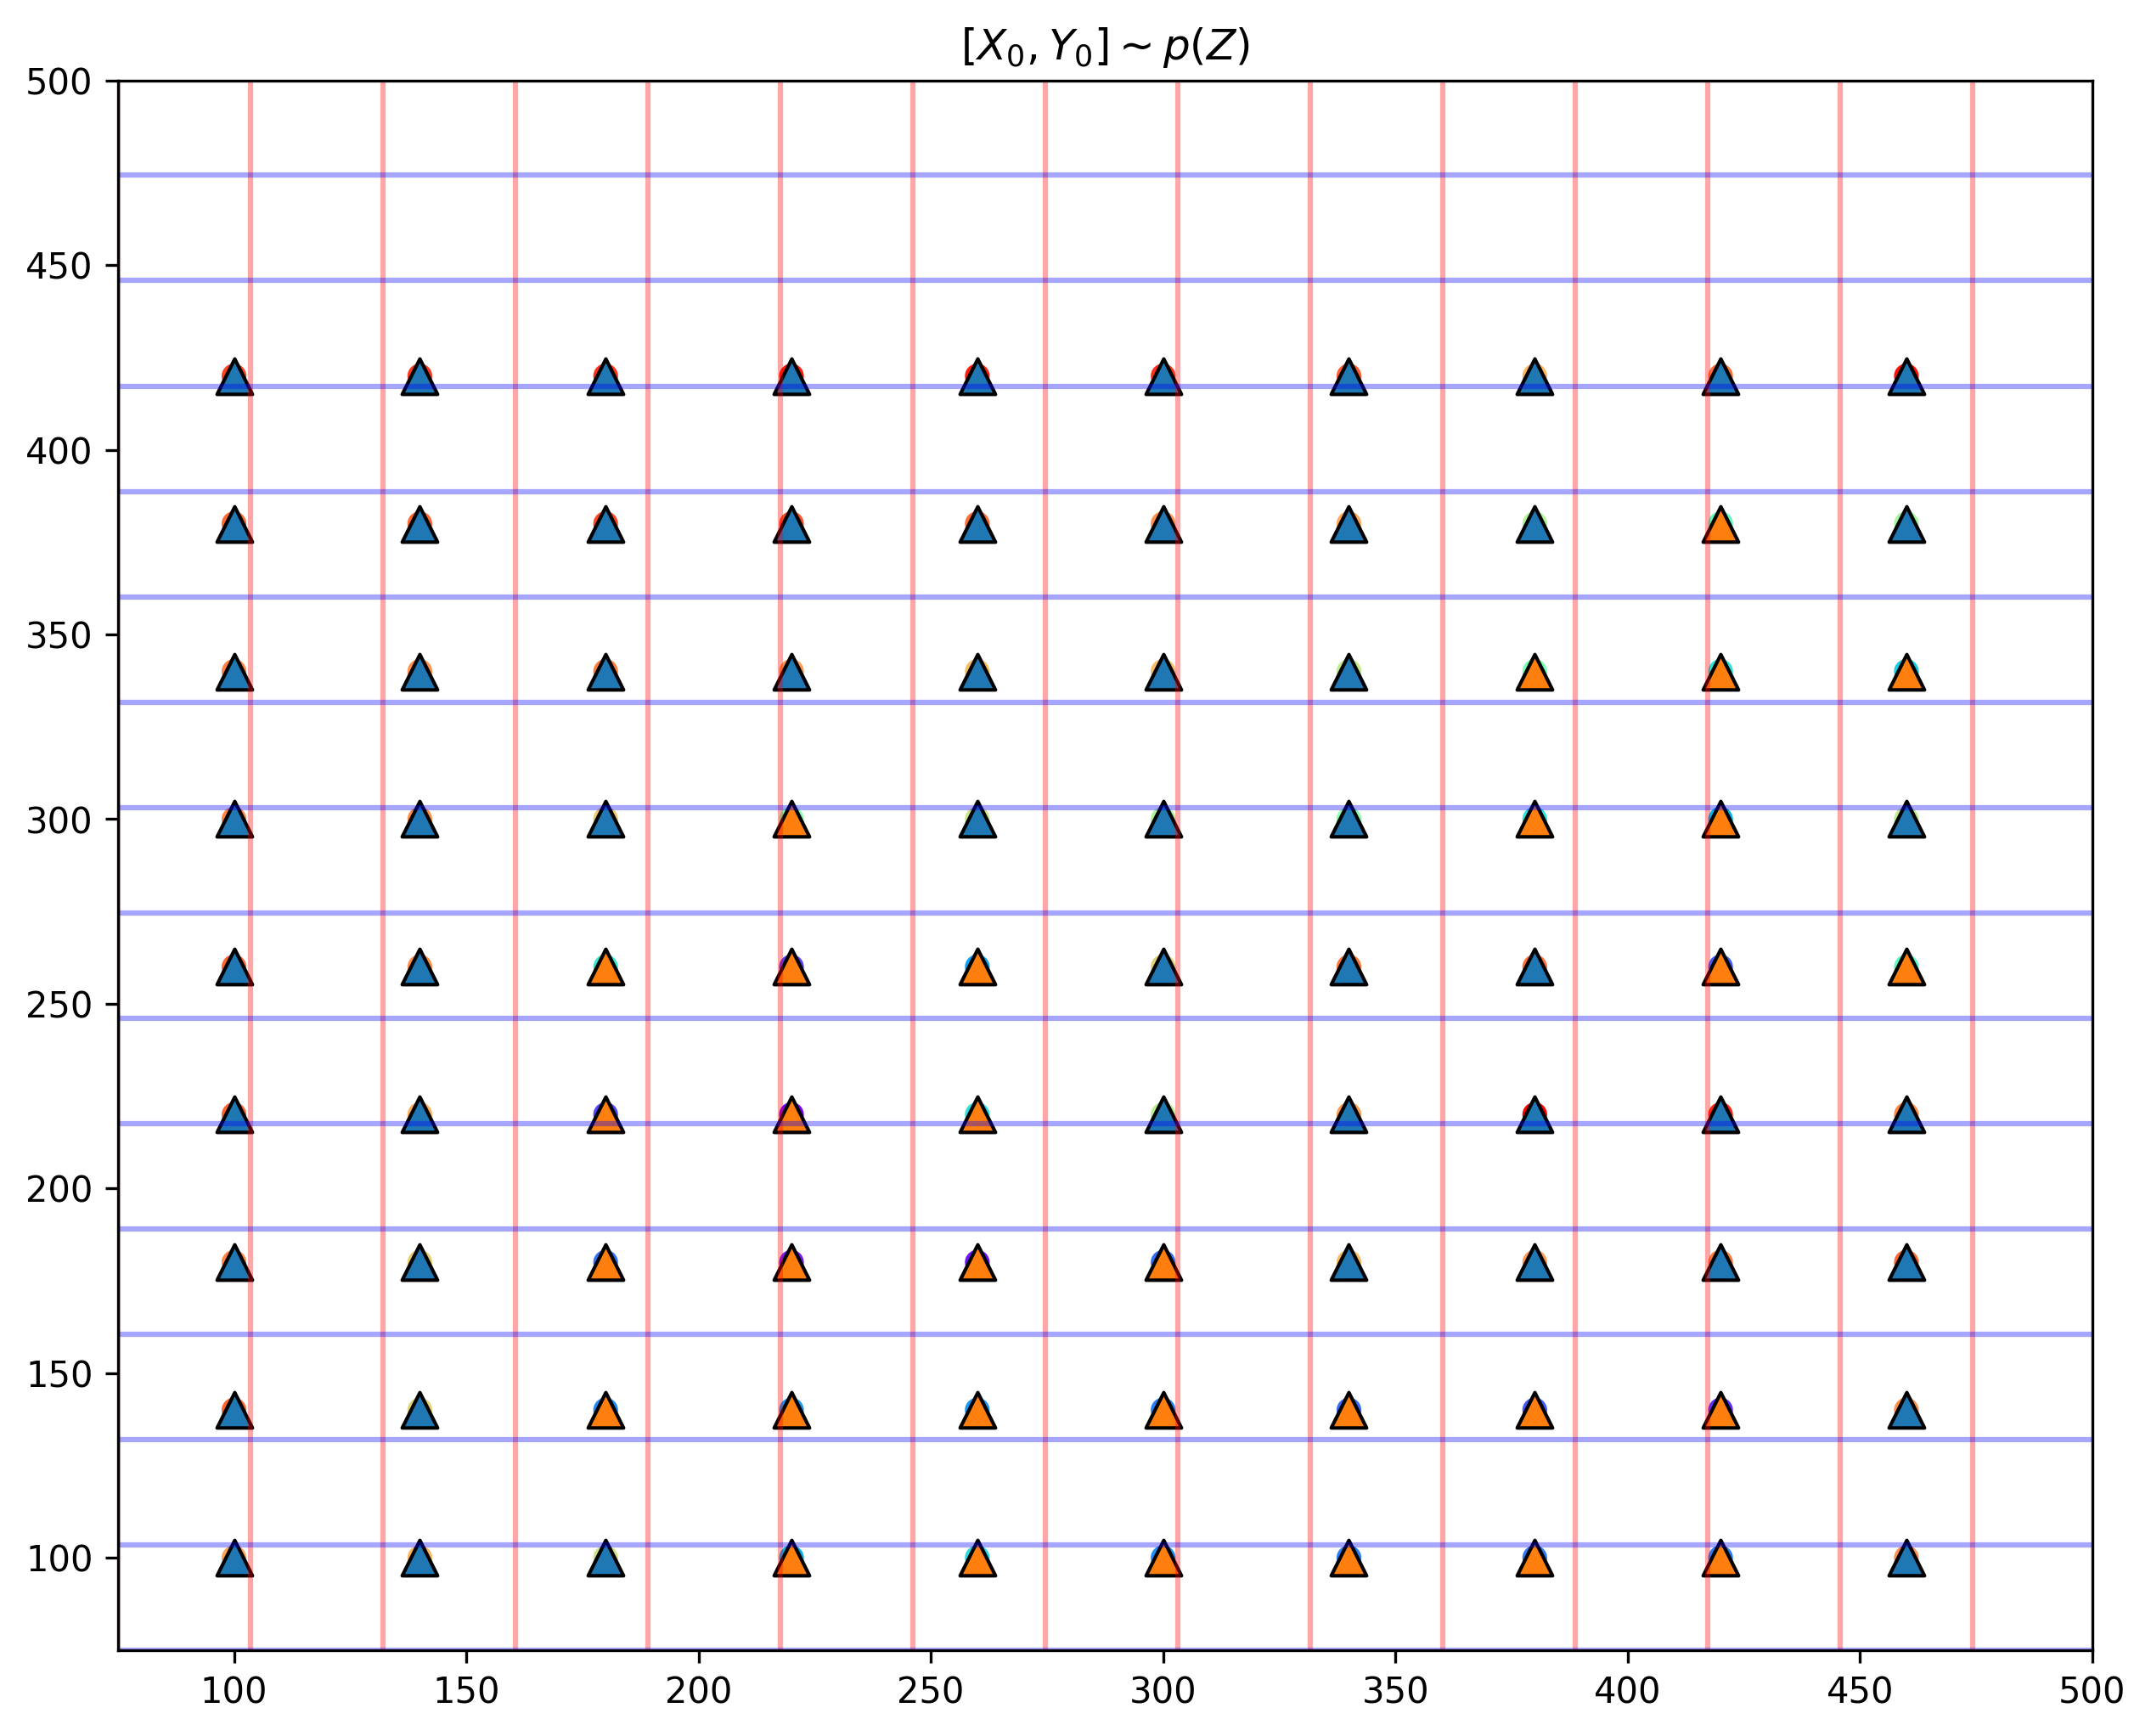

In [ ]:
plt.scatter(data[:, 0], data[:, 1], c=inv[:, 0], cmap=plt.cm.rainbow)
for i in range(int(np.max(labels) + 1)):
    plt.scatter(data[labels==i][:, 0], data[labels==i][:, 1], marker="^", s=100, edgecolor="k")
plt.plot(xx_x[:, ::grid_freq], yy_x[:, ::grid_freq], '-r', alpha=0.35)
plt.plot(yy_x[:, ::grid_freq], xx_x[:, ::grid_freq], '-b', alpha=0.35)
plt.title(r'$[X_0,Y_0] \sim p(Z)$')
plt.xlim(x_lims)
plt.ylim(x_lims)